full [0, 103.00116235351562, 206.00232470703125, 309.0034870605469, 412.0046494140625, 515.0058117675782, 618.0069741210938, 721.0081364746094, 824.009298828125, 927.0104611816406, 1030.0116235351563, 1133.012785888672, 1236.0139482421876, 1339.0151105957032, 1442.0162729492188, 1545.0174353027344, 1648.01859765625, 1751.0197600097656, 1854.0209223632812, 1957.0220847167968, 2060.0232470703127, 2163.0244094238283, 2266.025571777344, 2369.0267341308595, 2472.027896484375, 2575.0290588378907, 2678.0302211914063, 2781.031383544922, 2884.0325458984375, 2987.033708251953, 3090.0348706054688, 3193.0360329589844, 3296.0371953125, 3399.0383576660156, 3502.039520019531, 3605.040682373047, 3708.0418447265624, 3811.043007080078, 3914.0441694335937, 4017.0453317871093, 4120.046494140625, 4223.047656494141, 4326.048818847657, 4429.049981201172, 4532.051143554688, 4635.052305908203, 4738.053468261719, 4841.054630615235, 4944.05579296875, 5047.056955322266, 5150.058117675781, 5253.059280029297, 5356.

Text(0.5, 1.0, 'distilbert agnews')

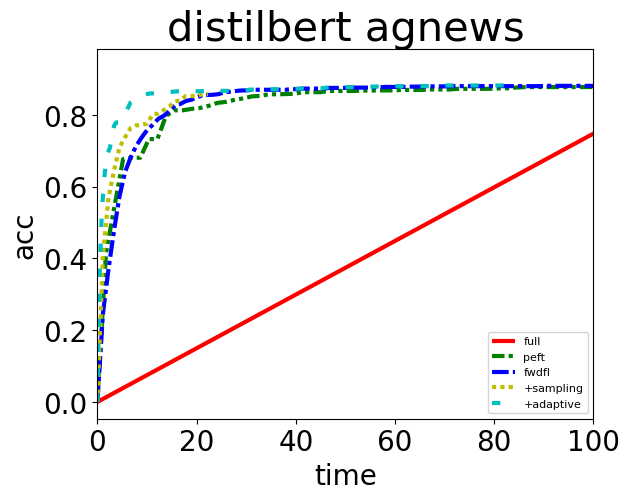

In [8]:
# figure 12

import os 
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

dataset = "agnews"
model = "distilbert"

train_time_dict = {"full":6.939,"fwdfl":0.3085584,"peft":4.1634,"+sampling":0.3085584,"+adaptive":0.3085584}

local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.85
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method in ["fwdfl",'+sampling','+adaptive']:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    elif method in ['full','peft']:
        time = (train_time*local_data_num*adhoc[0] + 2*comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + 2*comm_time)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method in ["fwdfl",'+sampling','+adaptive']:    
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        elif method in ['full','peft']:
            time += (train_time*local_data_num*v_num*eval_frequence + 2*comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*adhoc[0] + 2*comm_time)/60
        time_list.append(time)
    print(method,time_list)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

mode_dict = {
    'full':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_full.log',
    'peft':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_agnews/fedsgd_distilbert_agnews_lr0.01_client_num_10_adapter.log',
    'fwdfl':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_100_numerical_muti_v_10.log',
    '+sampling':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_100_numerical_v10_sampling_10.log',
    '+adaptive':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_100_numerical_adaptive_sampling_10.log'
}

time_to_acc_list = {}
for i,method in enumerate(mode_dict):
    
    file = mode_dict[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        adhoc = f'1,1,1'
        if method in ["fwdfl",'+sampling']:
            adhoc = '10,10,10'
        elif method == '+adaptive':
            adhoc = '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10'
        max_acc = 0
        for line in f:
            if "'acc':" in line:
                cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
                if cur_acc>max_acc:
                    max_acc = cur_acc
                else:
                    cur_acc = max_acc
                acc.append(cur_acc)
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        # time_to_acc_dict[client_num] = get_time_to_target_acc(target_acc,acc,time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
        time_to_acc_list[method] = (get_time_to_target_acc(target_acc,acc,time_list))

print(time_to_acc_list)
# plt.plot(range(len(time_to_acc_list)), time_to_acc_list, linestyle=linestyle[i+1], color=colors[i+1],label=method,linewidth=lw)


# plt.xticks(range(len(time_to_acc_list)),client_num_list)
plt.xlabel("time",fontsize=20)
plt.ylabel("acc",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,100)
plt.yticks(size = 20)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
# plt.show()
# plt.savefig("s.pdf",bbox_inches="tight")

full [0, 170.57308422851563, 341.14616845703125, 511.71925268554685, 682.2923369140625, 852.8654211425782, 1023.4385053710938, 1194.0115895996094, 1364.584673828125, 1535.1577580566407, 1705.7308422851563, 1876.303926513672, 2046.8770107421876, 2217.450094970703, 2388.0231791992187, 2558.5962634277344, 2729.16934765625, 2899.7424318847657, 3070.3155161132813, 3240.888600341797, 3411.4616845703126, 3582.0347687988283, 3752.607853027344, 3923.1809372558596, 4093.7540214843752, 4264.32710571289, 4434.900189941406, 4605.473274169922, 4776.046358398437, 4946.619442626953, 5117.192526855469, 5287.765611083984, 5458.3386953125, 5628.911779541016, 5799.484863769531, 5970.057947998047, 6140.631032226563, 6311.204116455078, 6481.777200683594, 6652.35028491211, 6822.923369140625, 6993.496453369141, 7164.069537597657, 7334.642621826172, 7505.215706054688, 7675.7887902832035, 7846.361874511719, 8016.934958740235, 8187.5080429687505, 8358.081127197265, 8528.65421142578, 8699.227295654297, 8869.80037

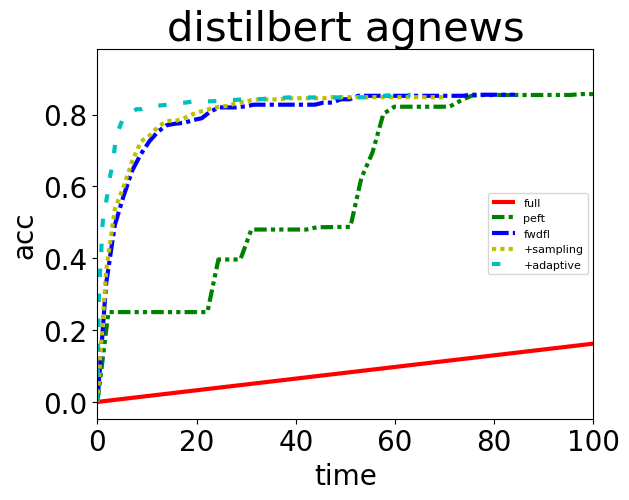

In [3]:
# figure 12

import os 
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

dataset = "agnews"
model = "distilbert"

train_time_dict = {"+sampling":0.669904,'fwdfl':0.669904,"+adaptive":0.669904,"peft":8.2235,"full":14.047}

local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.83
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method in ["fwdfl",'+sampling','+adaptive']:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    elif method in ['full','peft']:
        time = (train_time*local_data_num*adhoc[0] + 2*comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + 2*comm_time)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method in ["fwdfl",'+sampling','+adaptive']:    
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        elif method in ['full','peft']:
            time += (train_time*local_data_num*v_num*eval_frequence + 2*comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*adhoc[0] + 2*comm_time)/60
        time_list.append(time)
    print(method,time_list)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

mode_dict = {
    'full':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/bert_agnews/fedsgd_bert_agnews_lr0.01_client_num_10_full.log',
    'peft':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/bert_agnews/fedsgd_bert_agnews_lr0.01_client_num_10_bitfit.log',
    'fwdfl':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/bert_agnews/fedFwd_bert_agnews_lr0.01_client_num_100_numerical_v10.log',
    '+sampling':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/bert_agnews/fedFwd_bert_agnews_lr0.01_client_num_100_numerical_v10_sampling_10.log',
    '+adaptive':'/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/adaptive/bert_agnews/fedFwd_bert_agnews_lr0.01_client_num_100_numerical_adaptive_sampling_10.log'
}

time_to_acc_list = {}
for i,method in enumerate(mode_dict):
    
    file = mode_dict[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        adhoc = f'1,1,1'
        if method in ["fwdfl",'+sampling']:
            adhoc = '10,10,10'
        elif method == '+adaptive':
            adhoc = '1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 5, 5, 5, 5, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10'
        max_acc = 0
        for line in f:
            if "'acc':" in line:
                cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
                if cur_acc>max_acc:
                    max_acc = cur_acc
                else:
                    cur_acc = max_acc
                acc.append(cur_acc)
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        # time_to_acc_dict[client_num] = get_time_to_target_acc(target_acc,acc,time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
        time_to_acc_list[method] = (get_time_to_target_acc(target_acc,acc,time_list))

print(time_to_acc_list)
# plt.plot(range(len(time_to_acc_list)), time_to_acc_list, linestyle=linestyle[i+1], color=colors[i+1],label=method,linewidth=lw)


# plt.xticks(range(len(time_to_acc_list)),client_num_list)
plt.xlabel("time",fontsize=20)
plt.ylabel("acc",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,100)
plt.yticks(size = 20)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()
# plt.savefig("s.pdf",bbox_inches="tight")